In [30]:
#Import all libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS
import string
import seaborn as sns
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from gensim.models import Word2Vec, FastText
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

In [31]:
#creating word cloud for given corpus  
def make_wordcloud(corpus , stopword):
    word_cloud = WordCloud(
            width=3000,
            height=2000,
            random_state=1,
            background_color="black",
            colormap="Pastel1",
            collocations=False,
            stopwords=stopword,
            ).generate(corpus)
    return word_cloud

In [32]:
#This function swaps 2 columns inside the dataframe
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [33]:
#This function removes punctuation from string
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [34]:
#Reading dataset
Email_dataset = pd.read_csv("spam_ham_dataset.csv")

In [35]:
#Show dataset
Email_dataset.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [36]:
s=Email_dataset["label"].value_counts()
s

label
ham     3672
spam    1499
Name: count, dtype: int64

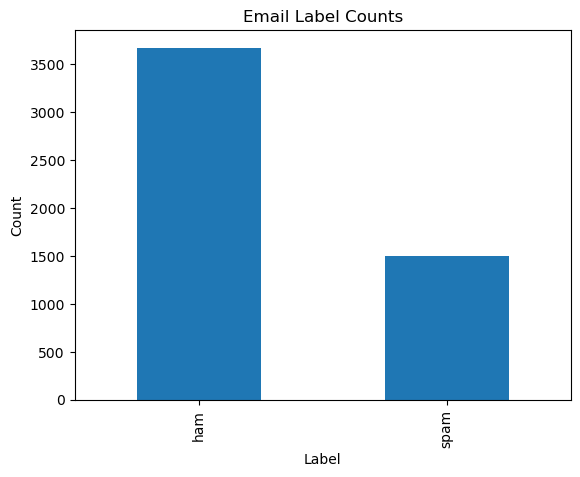

In [37]:
# create a bar chart
s.plot.bar()

# set the title and axis labels
plt.title("Email Label Counts")
plt.xlabel("Label")
plt.ylabel("Count")

# display the chart
plt.show()

In [38]:
#Dropping columns that are not needed
Email_dataset = Email_dataset.drop('Unnamed: 0', axis=1)
Email_dataset = Email_dataset.drop('label', axis=1)

In [39]:
Email_dataset.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [40]:
#Creating a new feature, extracting subject of each email
subjects = []
for i in range(len(Email_dataset)):
    ln = Email_dataset["text"][i]
    line = ""
    for i in ln:
        if(i == '\r'):
            break
        line = line + i
    line = line.replace("Subject" , "")
    subjects.append(line)

In [41]:
Email_dataset['Subject'] = subjects

In [42]:
#Renaming the dataframe columns
Email_dataset.columns = ["Email_text" , "Labels" , "Email_Subject"]

In [43]:
Email_dataset.head()

,Email_text,Labels,Email_Subject
0,Subject: enron methanol ; meter # : 988291\r\n...,0,: enron methanol ; meter # : 988291
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,": hpl nom for january 9 , 2001"
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,: neon retreat
3,"Subject: photoshop , windows , office . cheap ...",1,": photoshop , windows , office . cheap . main ..."
4,Subject: re : indian springs\r\nthis deal is t...,0,: re : indian springs


In [44]:
#Swapping the dataframe columns 
Email_dataset = swap_columns(Email_dataset, 'Labels', 'Email_Subject')

In [45]:
Email_dataset.head()

,Email_text,Email_Subject,Labels
0,Subject: enron methanol ; meter # : 988291\r\n...,: enron methanol ; meter # : 988291,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",": hpl nom for january 9 , 2001",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",: neon retreat,0
3,"Subject: photoshop , windows , office . cheap ...",": photoshop , windows , office . cheap . main ...",1
4,Subject: re : indian springs\r\nthis deal is t...,: re : indian springs,0


In [46]:
#Converting all strings to lowercase
Email_dataset['Email_Subject'] = Email_dataset['Email_Subject'].str.lower()
Email_dataset['Email_text'] = Email_dataset['Email_text'].str.lower()

In [47]:
#Removing Punctuation from the data
Email_dataset['Email_Subject'] = Email_dataset['Email_Subject'].apply(remove_punctuations)
Email_dataset['Email_text'] = Email_dataset['Email_text'].apply(remove_punctuations)

In [48]:
Email_dataset.head()

,Email_text,Email_Subject,Labels
0,subject enron methanol meter 988291\r\nthis...,enron methanol meter 988291,0
1,subject hpl nom for january 9 2001\r\n see at...,hpl nom for january 9 2001,0
2,subject neon retreat\r\nho ho ho we re aroun...,neon retreat,0
3,subject photoshop windows office cheap mai...,photoshop windows office cheap main trending,1
4,subject re indian springs\r\nthis deal is to ...,re indian springs,0


In [49]:
#Creting seprate dataset for Spam and Non Spam emails, to perform analysis 
Spam = pd.DataFrame(columns = ['Email_text', 'Email_Subject', 'Labels'])
Non_Spam = pd.DataFrame(columns = ['Email_text', 'Email_Subject', 'Labels'])

In [51]:
print(pd.__version__)

2.0.3


In [52]:
#Creating Non_Spam email dataset 
for i in range(len(Email_dataset)):
    if(Email_dataset['Labels'][i] == 0):
        new_row = {'Email_text':Email_dataset['Email_text'][i], 'Email_Subject':Email_dataset['Email_Subject'][i], 'Labels':Email_dataset['Labels'][i]}
        Non_Spam = Non_Spam.append(new_row, ignore_index=True)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
#Creating Spam email dataset 
for i in range(len(Email_dataset)):
    if(Email_dataset['Labels'][i] == 1):
        new_row = {'Email_text':Email_dataset['Email_text'][i], 'Email_Subject':Email_dataset['Email_Subject'][i], 'Labels':Email_dataset['Labels'][i]}
        Spam = Spam.append(new_row, ignore_index=True)

In [ ]:
Spam.head()

In [ ]:
Non_Spam.head()

In [ ]:
#creating stopwords corpus
more_stopwords = {'re' , 's' , 'subject','hpl','hou','enron'}
STOPWORDS = STOPWORDS.union(more_stopwords)

In [ ]:
#creating spam subject corpus 
Subject_corpus_spam = ""
for i in range(len(Spam)):
    Subject_corpus_spam = Subject_corpus_spam + Spam['Email_Subject'][i]

In [ ]:
#creating spam text corpus 
Text_corpus_spam = ""
for i in range(len(Spam)):
    Text_corpus_spam = Text_corpus_spam + Spam['Email_text'][i]

In [ ]:
#creating non-spam subject corpus 
Subject_corpus_non_spam = ""
for i in range(len(Non_Spam)):
    Subject_corpus_non_spam = Subject_corpus_non_spam + Non_Spam['Email_Subject'][i]

In [ ]:
#creating non-spam text corpus 
Text_corpus_non_spam = ""
for i in range(len(Non_Spam)):
    Text_corpus_non_spam = Text_corpus_non_spam + Non_Spam['Email_text'][i]

In [ ]:
#plotting word cloud for Spam Subject corpus
Spam_Subject_wordcloud = make_wordcloud (Subject_corpus_spam , STOPWORDS)
plt.figure(figsize=(13, 13))
plt.title("Most common words in Spam email Subjects", fontdict={'size': 20, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
plt.imshow(Spam_Subject_wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#plotting word cloud for Spam Text corpus
Spam_Text_wordcloud = make_wordcloud (Text_corpus_spam , STOPWORDS)
plt.figure(figsize=(13, 13))
plt.title("Most common words in Spam email", fontdict={'size': 20, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
plt.imshow(Spam_Text_wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#plotting word cloud for Non Spam Subject corpus
Non_Spam_Subject_wordcloud = make_wordcloud (Subject_corpus_non_spam , STOPWORDS)
plt.figure(figsize=(13, 13))
plt.title("Most common words in NON-Spam email subject", fontdict={'size': 20, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
plt.imshow(Non_Spam_Subject_wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#plotting word cloud for Non Spam Text corpus
Non_Spam_Subject_wordcloud = make_wordcloud (Text_corpus_non_spam , STOPWORDS)
plt.figure(figsize=(13, 13))
plt.title("Most common words in NON-Spam email", fontdict={'size': 20, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
plt.imshow(Non_Spam_Subject_wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#create a corpus conatininga all the email text 
Email_text_corpus = []
for line in Email_dataset['Email_text']:
    words = line.split(" ")
    Email_text_corpus.append(words)

In [ ]:
#create a word2vec model for words in email text 
model = Word2Vec(Email_text_corpus, min_count=1, vector_size=56)

In [ ]:
X = model.wv[model.wv.key_to_index ]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
pca_df = pd.DataFrame(result, columns = ['x','y'])

In [ ]:
#visualizing the corpus as a word vector
N = 1000000
words = list(model.wv.key_to_index)
fig = go.Figure(data=go.Scattergl(
   x = pca_df['x'],
   y = pca_df['y'],
   mode='markers',
   marker=dict(
       color=np.random.randn(N),
       colorscale='Viridis',
       line_width=1
   ),
   text=words,
   textposition="bottom center"
))

fig.show()

In [ ]:
Email_dataset.head()

Binary Logistic Regression is a statistical method for predicting binary classes. The outcome or target variable is dichotomous in nature. Dichotomous means there are only two possible classes. In our case, these classes are "ham" and "spam".

In logistic regression, we use the sigmoid function to output probabilities. These probabilities then can be converted to class predictions. The sigmoid function maps any value into another value between 0 and 1.

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

The cost function for logistic regression, sometimes called log loss, measures the performance of a classification model. Here are the key points:

* It calculates the error for a single training example.
* The cost is calculated as the negative sum of the actual value times the natural log of the predicted value and the difference of the actual value from one times the natural log of the difference of the predicted value from one.
* The formula for the cost function for a single training example is -y * log(h) - (1 - y) * log(1 - h).
* If the actual class is 1 (y = 1) and the model correctly predicts 1 (h = 1), then the cost is 0.
* If the actual class is 1 (y = 1) but the model predicts 0 (h = 0), then the cost is infinite.
* The same applies when the actual class is 0 (y = 0).
* When you calculate the cost function over the entire training set, it's called the average cost function, and you take the average of all the individual costs.



The cost function in logistic regression is a log loss function, also known as cross-entropy loss. When dealing with logistic regression, it's more suitable than mean squared error as a loss function because it's convex, which avoids problems with local minimums that are not global minimums. It's defined as:

**J(w) = -1/n Σ [y * log(h(x)) + (1 - y) * log(1 - h(x))]**

This equation might look complex, but it's essentially an average of loss values where the loss is calculated per individual prediction. Let's break it down:

* h(x): this is the prediction your model makes for the input x. For logistic regression, it's the output of the sigmoid function applied to the weighted sum of the input features.

* y * log(h(x)): This part of the function calculates the loss for positive examples (where the actual value y is 1). If the actual value is 1 and the model predicts 1 (h(x) close to 1), the loss is 0 because log(1) = 0. But if the model predicts 0 (h(x) close to 0), the loss goes to infinity because log(0) approaches negative infinity, so we get a very large penalty for a false negative.

* (1 - y) * log(1 - h(x)): This part of the function calculates the loss for negative examples (where the actual value y is 0). If the actual value is 0 and the model predicts 0 (h(x) close to 0), the loss is 0 because log(1) = 0. But if the model predicts 1 (h(x) close to 1), log(1 - h(x)) approaches negative infinity, so we get a large penalty for a false positive.

* -1/n Σ: Finally, we sum up all these loss values for each example in our dataset and divide by the number of examples to compute the average loss, which is the value that the log loss function returns.

* 1e-10 is a very small number that should prevent the values inside the log from becoming 0.

By minimizing this cost function, we can optimize the parameters of our logistic regression model to make the best predictions possible. The cost function is ideal because it penalizes confidently wrong predictions more than it rewards confidently correct ones, and because it's differentiable, allowing us to use efficient optimization algorithms like gradient descent.

In [ ]:
def cost_function(h, y):
    return (-y * np.log(h + 1e-10) - (1 - y) * np.log(1 - h + 1e-10)).mean()

Gradient Descent is used while training a machine learning model. It's an optimization algorithm, used to minimize some function by iteratively moving in the direction of steepest descent as defined by the negative of the gradient.

In [ ]:
def gradient_descent(X, h, y):
    return np.dot(X.T, (h - y)) / y.shape[0]

Weights are updated iteratively by taking steps proportional to the negative of the gradient.

In [ ]:
def update_weight_loss(weight, learning_rate, gradient):
    return weight - learning_rate * gradient

Convert the 'Email_text' column to a matrix of token counts.

In [ ]:
X = Email_dataset['Email_text']
y = Email_dataset['Labels'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Fit the CountVectorizer on your training data
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train).toarray()

# Transform your test data using the same vectorizer
X_test = vectorizer.transform(X_test).toarray()

In [ ]:
num_iter = 1000
learning_rate = 0.1
weight = np.zeros(X_train.shape[1])

In [ ]:
costs = []

In [ ]:
for i in range(num_iter):
    z = np.dot(X_train, weight)
    h = sigmoid(z)
    gradient = gradient_descent(X_train, h, y_train)
    weight = update_weight_loss(weight, learning_rate, gradient)
    
    if(i % 100 == 0):
        z = np.dot(X_train, weight)
        h = sigmoid(z)
        cost = cost_function(h, y_train)
        costs.append(cost)
        print(f'cost: {cost} \t')

In [ ]:
plt.plot(costs)
plt.xlabel('Epochs (x100)')
plt.ylabel('Cost')
plt.title('Cost over Epochs')
plt.show()

In [ ]:
final_pred = sigmoid(np.dot(X_test, weight))
y_pred = final_pred.round()

In [ ]:
print('Classification Report:')
print(classification_report(y_test, y_pred))